In [1]:
import json
import numpy as np
import torch
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformers import BertTokenizer, BertModel

In [2]:
from task_distill import (
    ColaProcessor,
    MnliProcessor,
    MnliMismatchedProcessor,
    MrpcProcessor,
    Sst2Processor,
    StsbProcessor,
    QqpProcessor,
    QnliProcessor,
    RteProcessor,
    WnliProcessor,
)
from task_distill import convert_examples_to_features, get_tensor_data

In [3]:
processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor,
    "wnli": WnliProcessor
}

In [4]:
output_modes = {
    "cola": "classification",
    "mnli": "classification",
    "mnli-mm": "classification",
    "mrpc": "classification",
    "sst-2": "classification",
    "sts-b": "regression",
    "qqp": "classification",
    "qnli": "classification",
    "rte": "classification",
    "wnli": "classification"
}

#### Load Dataset

In [5]:
task_name = 'sst-2'
data_dir = '/home/mila/c/caomeng/scratch/glue_data/{}'.format(task_name.upper())

In [6]:
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

In [7]:
examples = []
train_examples = processor.get_train_examples(data_dir)
dev_examples = processor.get_dev_examples(data_dir)
print('- train examples: {}'.format(len(train_examples)))
print('- dev examples: {}'.format(len(dev_examples)))
examples.extend(train_examples)
examples.extend(dev_examples)

if task_name == 'mnli':
    processor = processors['mnli-mm']()
    dev_mismatched_examples = processor.get_dev_examples(data_dir)
    print('- dev mismatched examples: {}'.format(len(dev_mismatched_examples)))
    examples.extend(dev_mismatched_examples)

- train examples: 67349
- dev examples: 872


In [8]:
len(examples)

68221

#### Convert Examples to Features

In [9]:
teacher_model_path = '/home/mila/c/caomeng/scratch/huggingface/bert-base-uncased'

In [10]:
train_guids = []

for e in examples:
    train_guids.append(e.guid)

In [11]:
tokenizer = BertTokenizer.from_pretrained(teacher_model_path, local_files_only=True)

In [12]:
max_seq_length = 128
train_features = convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode)

03/30 04:01:14 PM Writing example 0 of 68221
03/30 04:01:14 PM *** Example ***
03/30 04:01:14 PM guid: train-1
03/30 04:01:14 PM tokens: [CLS] hide new secret ##ions from the parental units [SEP]
03/30 04:01:14 PM input_ids: 101 5342 2047 3595 8496 2013 1996 18643 3197 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/30 04:01:14 PM input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/30 04:01:14 PM segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [13]:
print(len(train_features))
print(train_features[0])

68221


In [14]:
train_data, all_label_ids = get_tensor_data(output_mode, train_features)

In [15]:
train_data.tensors[0].shape

torch.Size([68221, 128])

In [16]:
print(all_label_ids.shape)
print(all_label_ids[:10])

torch.Size([68221])
tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 1])


In [17]:
train_dataloader = DataLoader(train_data, sampler=SequentialSampler(train_data), batch_size=32)

#### Load Teacher Model

In [18]:
teacher_model = BertModel.from_pretrained(teacher_model_path, local_files_only=True)
teacher_model.to('cuda')

Some weights of the model checkpoint at /home/mila/c/caomeng/scratch/huggingface/bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [19]:
cls_features = []
example_ids = []

for batch_ in tqdm(train_dataloader, desc="Evaluating"):
    batch_ = tuple(t.to('cuda') for t in batch_)
    with torch.no_grad():
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_
        pooled = teacher_model(input_ids, segment_ids, input_mask, return_dict=True).pooler_output

        cls_features.append(pooled)
        example_ids.append(input_ids)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2132/2132 [00:32<00:00, 65.92it/s]


In [20]:
cls_feature_vectors = torch.cat(cls_features, dim=0)

In [21]:
cls_feature_vectors.shape

torch.Size([68221, 768])

#### K-means

In [22]:
%matplotlib inline

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [24]:
cls_feature_numpy = cls_feature_vectors.cpu().numpy()
all_label_ids = all_label_ids.cpu().numpy()

In [25]:
assert cls_feature_numpy.shape[0] == all_label_ids.shape[0]

In [26]:
CLUSTER_NUMBER = 4
kmeans = KMeans(n_clusters=CLUSTER_NUMBER, random_state=0).fit(cls_feature_numpy)

In [27]:
cluster_centers = kmeans.cluster_centers_

In [28]:
cluster_labels = kmeans.labels_

In [29]:
print(cluster_centers.shape)
print(cluster_labels.shape)

(4, 768)
(68221,)


In [30]:
cluster_labels[:10]

array([2, 0, 3, 1, 0, 0, 3, 2, 0, 1], dtype=int32)

#### Save Clustering IDs

In [31]:
assert len(train_guids) == cluster_labels.shape[0]

In [32]:
cluster_map = {}

for guid, l in zip(train_guids, cluster_labels):
    cluster_map[guid] = int(l)

In [33]:
# import json

# with open('clusters/cluster_sst2_k{}.json'.format(CLUSTER_NUMBER), 'w') as fp:
#     json.dump(cluster_map, fp)

#### Visualization

In [34]:
import random

from sklearn.decomposition import PCA

In [35]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [36]:
vis_data = cls_feature_numpy[:10000, :]
vis_labels = cluster_labels[:10000]

In [37]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(vis_data)

In [38]:
pca_results.shape

(10000, 2)

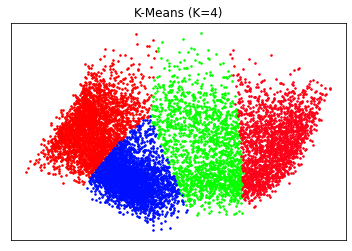

In [39]:
plt.figure(1)

cmap = get_cmap(CLUSTER_NUMBER)

for k in range(CLUSTER_NUMBER):
    cluster_data = vis_labels == k
    plt.scatter(pca_results[cluster_data, 0], pca_results[cluster_data, 1],
                color=cmap(k), marker='.', s=10)

# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=50)
plt.title("K-Means (K={})".format(CLUSTER_NUMBER))
plt.xticks([])
plt.yticks([])
plt.savefig('kmeans.png')
plt.show()

In [40]:
vis_labels = all_label_ids[:10000]

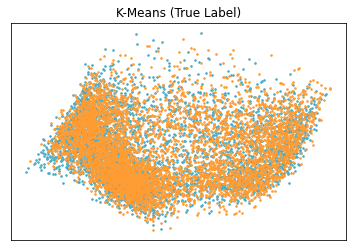

In [41]:
plt.figure(1)

cmap = ['#4EACC5', '#FF9C34', '#4E9A06']

for k in range(3):
    cluster_data = vis_labels == k
    plt.scatter(pca_results[cluster_data, 0], pca_results[cluster_data, 1],
                color=cmap[k], marker='.', s=10)

# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=50)
plt.title("K-Means (True Label)")
plt.xticks([])
plt.yticks([])
plt.savefig('ture_label.png')
plt.show()

In [42]:
# merge json
# train_json = json.load(open('clusters/cluster_mnli_k3_train.json'))
# dev_m_json = json.load(open('clusters/cluster_mnli_k3_dev_matched.json'))
# dev_mm_json = json.load(open('clusters/cluster_mnli_k3_dev_mismatched.json'))

# print(len(train_json))
# print(len(dev_m_json))
# print(len(dev_mm_json))

In [43]:
# with open('clusters/cluster_mnli_k{}.json'.format(CLUSTER_NUMBER), 'w') as fp:
#     json.dump({**train_json, **dev_m_json, **dev_mm_json}, fp)